In [1]:
import numpy as np
from matplotlib import pyplot as plt
from metpy import calc as mcalc
from metpy.units import units
import cmocean

C:\Users\icast\Anaconda3\lib\site-packages\xarray\core\merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


# Discussion

In Dimiceli et al. (2011), the NWS Tulsa office sought to derive an equation to estimate the Wet Bulb Globe Temperature (WBGT) using standard meteorological measurements. WBGT is an index that estimates the heat stress on an adult performing a physically strenuous task. In this case, the formulation for WBGT will be the outdoors version.

WBGT is calculated using the following simple formula when being measured directly:
>WBGT = .7Tw + .2Tg + .1Ta
>Where Tw is the wet bulb temperature, Tg is the globe temperature, and Ta is the ambient temperature.

While Tw and Ta are commonly measured, Tg is not. Because of this, an estimation of Tg was derived by the NWS Tulsa office and tested against measurements from an actual globe thermometer they built in 2010.

In this document, we implement the derived equation for estimating WBGT from Dimiceli et al. (2011) and show how it compares to another estimation used by the Australian Bureau of Meteorology.

## A Couple of Considerations

### h (coefficient of heat diffusion)
In the NWS paper, there is a variable h (the coefficient of heat diffusion) that the authors determined could be estimated using a calculation involving several constants and the S (solar irradiance) and the z (zenith angle). The constants used in the paper are never given values, and then when test cases for the calculation of WBGT are provided at the end of the paper they use a constant value for h, 0.315. In the future is may be prudent to get the values of the constants, thus making the h value dynamic.

### Fdb (direct solar beam radiation) and Fdif (diffuse solar radiation)
These values are typically assumed to be constants in the literature, as not many sites and measure them directly. In Dimiceli et al. (2011), the first of three test cases for the WBGT algorithm use values of 0.67 and 0.33 for the Fdb and Fdif values respectively. These values are changed to .75 and .25 in the next two cases, and the reasoning isn't mentioned.

## In Conclusion

Dimiceli et al. (2011) showed that this approximation of WBGT is extremely accurate, to within half a degree C. Our implementation below reproduces the numbers they got almost exactly. This, in our opinion, is a good approximation of WBGT that could be made better by clearing up the issues listed above.

##### Small side note: units not working properly yet, we (I, Isaac, will take the blame for that one) tried and couldn't get everything working smoothly so they have been omitted for now.

# Definitions Used

In [10]:
def T_Td_to_RH(T,Td):
    
    return 100*(np.exp((17.625*Td)/(243.04+Td))/np.exp((17.625*T)/(243.04+T)))


def centers_to_edges_1d(x):
    
    dx = np.absolute(x[0]-x[1])/2
    
    return np.arange(np.min(x)-dx,np.max(x)+dx+(dx/2),2*dx)


def TW(Temp,Td):
    
    # Uses 2/3 rule to estimate the wet bulb temperature
    return (2/3)*Temp + (1/3)*Td

    
def calcH(S,cosZ,a=10.27385542,b=-.9999702178,c=-22.35542742):
    
    return a*(S**b)*(cosZ**c)


def WBGT_NWS(u,Ta,Td,S,z,P,WBT,Fdb=0.67,Fdif=0.33,h=.315,calc_h=False):
    
    """
        Calculates WBGT using the algorithm in the nws experiment (1).
        WBGT is an improvement on the heat index, and is intended to 
        measure the heat impact on a person who is performing physical
        labor.
        
        
        In:
            u (miles per hour) (SFC wind speed)
            Ta (degC) (Ambient temperature)
            Td (degC) (Dewpoint temp)
            S (W/m^2) (Solar Irradiance)
            z (rad) (Zenith angle)
            P (hPa) (SFC barometric pressure)
            WBT (degC) (Wet bulb temperature)
            Fdb (units? unitless?) (Direct solar beam radiation)
            Fdif (unitless?) (Diffuse solar radiation)
            h (unitless) (Coeff of heat diffusion)
            
            calc_h (bool) (if true, use z and S to calculate more accurate h)
            
        Out:
            WBGT (degF) (Wet Bulb Globe Temperature)
            
        Default values for Fdb and Fdif from Hunter and Minyard (1999) (2)
        
        (1) https://www.weather.gov/media/tsa/pdf/WBGTpaper2.pdf
        
        (2) https://sti.srs.gov/fulltext/ms9900757/ms9900757.pdf
    
    """
    
    print("WBT:  ",WBT)
    
    # Convert u from mph to meters per hour
    u = u*1609.34
    
    # Calculate the cos of Z
    cosZ = np.cos(z)
    print("cosZ: ",cosZ)
    
    # Determine the value of h
    if calc_h:
        h = calcH(S,cosZ)
    print("h:    ",h)
    
    # Calculate the atmospheric vapor pressure (ea)
    ea = np.exp((17.67*(Td-Ta))/(Td+243.5))*(1.0007 + (0.00000346*P))*6.112*np.exp((17.502*Ta)/(240.97+Ta))
    #ea = 6.112*np.exp((Td*17.67)/(Td+243.5))
    print("ea:   ",ea)
    
    # Calculate thermal emissivity (Ea)
    Ea = .575*(ea**(1/7))
    print("Ea:   ",Ea)
    
    # Calculate B (as defined in (1))
    sig = 5.67*(10**-8)
    B = (S*(((Fdb)/(4*sig*cosZ)) + ((1.2)/(sig))*Fdif) + Ea*(Ta**4))
    print("B:    ",B)
    
    # Calculate C (")
    C = (h*(u**.58))/(5.3865*(10**-8))
    print("C:    ",C)
    
    # Combine to calculate GT
    GT = (B + (C*Ta) + 7680000) / (C + 256000)
    print("GT:   ",GT,"\n")
    
    # Calculate the WBGT
    WBGT = WBT*.7 + GT*.2 + Ta*.1
    
    return WBGT


def WBGT_AUS(Ta, RH):
    
    pressure = (RH/100) * 6.105*np.exp((17.27*Ta)/(237.7+Ta))
    WBGT = 0.567*Ta + 0.393*pressure +  3.94
    
    return WBGT


def Heat_Index(Temp, RH, W):
    
    e = (RH/100) * 6.105*np.exp((17.27*Temp)/(237.7+Temp))

    HI = Temp + 0.33*e-(0.70*W) - 4
    print(HI.size)
    
    return HI

# Reproduction of Dimiceli et al. (2011)

In [11]:
T,Td,WBT = 30,20.5,26.7755045
print("Case 1:")
print("WBGT =",WBGT_NWS(6,T,Td,336,0.6707,992.83,WBT))
print()
print()
print("Case 2:")
T,Td,WBT = 33.889,24.444,26.5755611
print("WBGT =",WBGT_NWS(7,T,Td,754,0.6397,981.94,WBT,Fdb=.75,Fdif=.25))
print()
print()
print("Case 3:")
T,Td,WBT = 34.444,21.111,26.34526836
print("WBGT =",WBGT_NWS(3.7,T,Td,579,0.7227,991.84,WBT,Fdb=.75,Fdif=.25))

Case 1:
WBT:   26.7755045
cosZ:  0.7833867836891231
h:     0.315
ea:    22.561247578273452
Ea:    0.8974400193356646
B:     3614446616.26237
C:     1197256882.1885445
GT:    33.0182945586829 

WBGT = 28.34651206173658


Case 2:
WBT:   26.5755611
cosZ:  0.8022748804197051
h:     0.315
ea:    28.485723358606265
Ea:    0.9278371082802895
B:     7098536970.838708
C:     1309231603.4343324
GT:    39.309090551620585 

WBGT = 29.85361088032412


Case 3:
WBT:   26.34526836
cosZ:  0.7500226523594646
h:     0.315
ea:    22.48575903763175
Ea:    0.8970104345200154
B:     5617587572.209012
C:     904516756.8734263
GT:    40.651580705256286 

WBGT = 30.016403993051256


# Comparison Between Dimiceli and Australian Methods

WBT:   [[20.         21.         22.         23.         24.         25.
  26.         27.         28.         29.         30.         31.
  32.         33.         34.         35.         36.         37.
  38.         39.         40.         41.         42.         43.
  44.         45.         46.         47.         48.         49.
  50.        ]
 [19.7249555  20.72286721 21.72077104 22.71866701 23.7165551  24.71443531
  25.71230766 26.71017214 27.70802874 28.70587747 29.70371833 30.70155133
  31.69937645 32.6971937  33.69500308 34.6928046  35.69059824 36.68838402
  37.68616192 38.68393196 39.68169414 40.67944844 41.67719488 42.67493345
  43.67266415 44.67038699 45.66810196 46.66580906 47.6635083  48.66119968
  49.65888319]
 [19.43689536 20.43262702 21.42834266 22.42404229 23.41972591 24.41539353
  25.41104514 26.40668074 27.40230034 28.39790393 29.39349152 30.38906311
  31.3846187  32.38015829 33.37568189 34.37118948 35.36668108 36.36215669
  37.35761631 38.35305993 39.34848756 40.

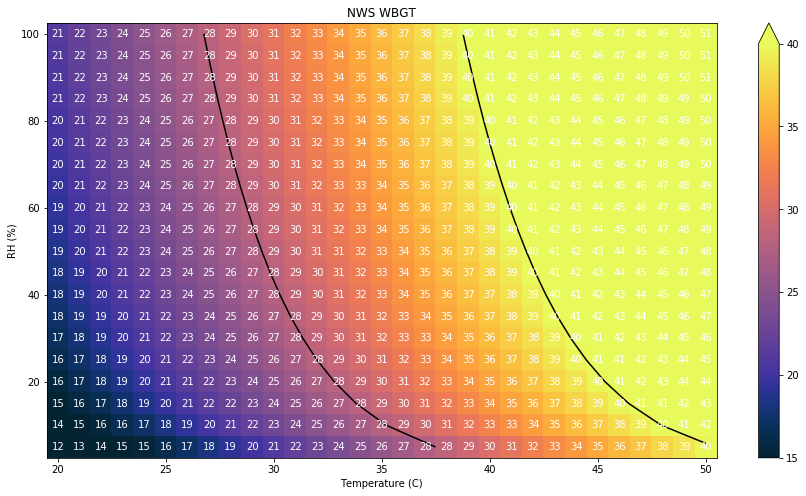

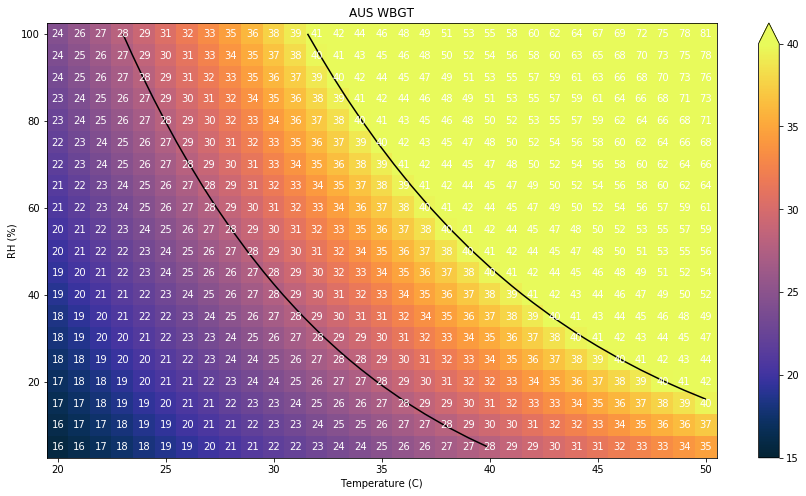

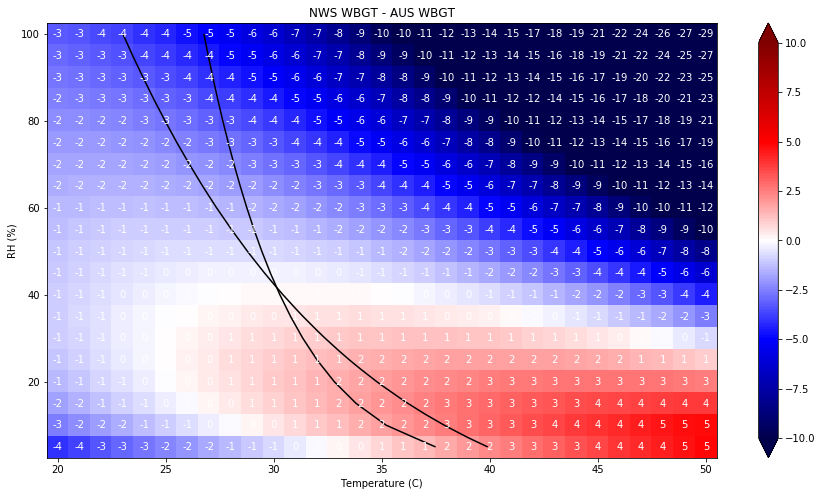

In [10]:
# Ranges of temperatures and relative humidities
temps = np.arange(20,51,1)
rhs = np.arange(100,0,-5)

# Create 2D arrays, convert from RH to dewpoint
tr,rt = np.meshgrid(temps,rhs)
dw = mcalc.dewpoint_rh(tr*units("degC"), rt/100).m
T,Td=tr,dw

# Calculate WBGT using the two methods
vals1 = WBGT_NWS(3.7,T,Td,579,0.7227,991.84,TW(T,Td),Fdb=.75,Fdif=.25)
vals2 = WBGT_AUS(tr,rt)

### Plots ###

# USA
vals = vals1
fig = plt.figure(figsize=(15,8))
plt.pcolormesh(centers_to_edges_1d(temps),np.flip(centers_to_edges_1d(rhs)),vals,vmin=15,vmax=40,cmap=cmocean.cm.thermal)
plt.colorbar(extend="max")
plt.contour(temps,rhs,vals,levels=(28,40),colors='k')

for i in range(len(vals.flatten())):
    plt.text(tr.flatten()[i],rt.flatten()[i],str(int(np.round(vals.flatten()[i]))),c='white',
            horizontalalignment='center',verticalalignment='center')

plt.xlabel("Temperature (C)")
plt.ylabel("RH (%)")
plt.title("NWS WBGT")
#plt.savefig("NWS_comp.png",dpi=300)
plt.show()

# AUS
vals = vals2
fig = plt.figure(figsize=(15,8))
plt.pcolormesh(centers_to_edges_1d(temps),np.flip(centers_to_edges_1d(rhs)),vals,vmin=15,vmax=40,cmap=cmocean.cm.thermal)
plt.colorbar(extend="max")
plt.contour(temps,rhs,vals,levels=(28,40),colors='k')

for i in range(len(vals.flatten())):
    plt.text(tr.flatten()[i],rt.flatten()[i],str(int(np.round(vals.flatten()[i]))),c='white',
            horizontalalignment='center',verticalalignment='center')

plt.xlabel("Temperature (C)")
plt.ylabel("RH (%)")
plt.title("AUS WBGT")
#plt.savefig("AUS_comp.png",dpi=300)
plt.show()

# DIF
vals = vals1 - vals2
fig = plt.figure(figsize=(15,8))
plt.pcolormesh(centers_to_edges_1d(temps),np.flip(centers_to_edges_1d(rhs)),vals,vmin=-10,vmax=10,cmap="seismic")
plt.colorbar(extend="both")
plt.contour(temps,rhs,vals1,levels=(28,),colors='k')
plt.contour(temps,rhs,vals2,levels=(28,),colors='k')

for i in range(len(vals.flatten())):
    plt.text(tr.flatten()[i],rt.flatten()[i],str(int(np.round(vals.flatten()[i]))),c='white',
            horizontalalignment='center',verticalalignment='center')

plt.xlabel("Temperature (C)")
plt.ylabel("RH (%)")
plt.title("NWS WBGT - AUS WBGT")
#plt.savefig("diff_comp.png",dpi=300)
plt.show()

# Sensitivity to Fdb, Wind, and Solar Irradiance

WBT:   26.7755045
cosZ:  0.7833867836891231
h:     0.315
ea:    22.561247578273452
Ea:    0.8974400193356646
B:     [7.11183804e+09 5.80684124e+09 4.50184444e+09 3.19684764e+09
 1.89185084e+09]
C:     1309231603.4343324
GT:    [35.4310083  34.43443773 33.43786717 32.44129661 31.44472604] 

WBT:   26.5755611
cosZ:  0.8022748804197051
h:     0.315
ea:    28.485723358606265
Ea:    0.9278371082802895
B:     [1.59588957e+10 1.30054428e+10 1.00519899e+10 7.09853697e+09
 4.14508405e+09]
C:     1197256882.1885445
GT:    [47.21486931 44.74854684 42.28222438 39.81590191 37.34957944] 

WBT:   26.34526836
cosZ:  0.7500226523594646
h:     0.315
ea:    22.48575903763175
Ea:    0.8970104345200154
B:     [1.22552308e+10 1.00426831e+10 7.83013532e+09 5.61758757e+09
 3.40503983e+09]
C:     800921486.418682
GT:    [49.73910421 46.97748424 44.21586427 41.4542443  38.69262433] 



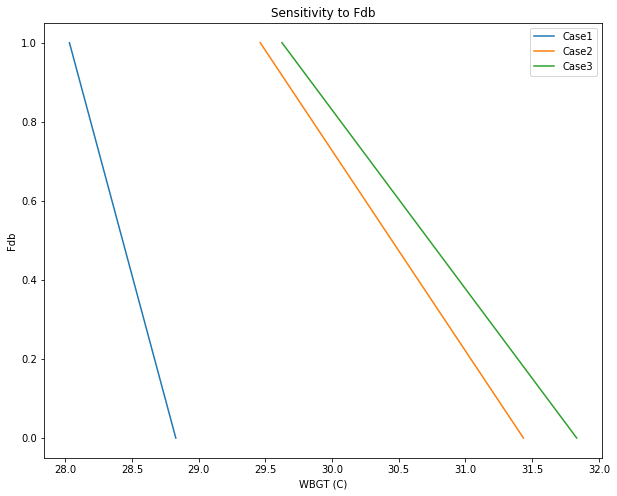

In [14]:
#changing Fdb and Fdif

Fdb = np.arange(0,1.25,.25)
Fdif = 1-Fdb

T,Td,WBT = 30,20.5,26.7755045
case1 = WBGT_NWS(7,T,Td,336,0.6707,992.83,WBT,Fdb,Fdif)

T,Td,WBT = 33.889,24.444,26.5755611
case2 = WBGT_NWS(6,T,Td,754,0.6397,981.94,WBT,Fdb,Fdif)

T,Td,WBT = 34.444,21.111,26.34526836 
case3 = WBGT_NWS(3,T,Td,579,0.7227,991.84,WBT,Fdb,Fdif)

fig, ax = plt.subplots(figsize=(10,8))
plt.plot(case1,Fdb,label='Case1')
plt.plot(case2,Fdb,label='Case2')
plt.plot(case3,Fdb,label='Case3')
plt.title('Sensitivity to Fdb')
plt.legend()
fig.patch.set_facecolor('white')
plt.xlabel('WBGT (C)')
plt.ylabel('Fdb')
plt.show()

WBT:   26.7755045
cosZ:  0.7833867836891231
h:     0.315
ea:    22.561247578273452
Ea:    0.8974400193356646
B:     3614446616.26237
C:     [6.33077698e+08 9.46355721e+08 1.19725688e+09 1.41465914e+09
 1.61012509e+09 1.78971855e+09 1.95710388e+09 2.11470215e+09
 2.26421504e+09 2.40689428e+09 2.54369345e+09 2.67535943e+09
 2.80249056e+09 2.92557526e+09 3.04501856e+09 3.16116092e+09
 3.27429186e+09 3.38466014e+09 3.49248141e+09 3.59794410e+09]
GT:    [35.70701769 33.81829903 33.01829456 32.55453244 32.24446663 32.01927263
 31.84659278 31.70899203 31.59615493 31.50154589 31.42080127 31.3508842
 31.28960879 31.23535717 31.18690336 31.14329957 31.10380021 31.0678098
 31.03484637 31.00451518] 

WBT:   26.5755611
cosZ:  0.8022748804197051
h:     0.315
ea:    28.485723358606265
Ea:    0.9278371082802895
B:     7098536970.838708
C:     [6.33077698e+08 9.46355721e+08 1.19725688e+09 1.41465914e+09
 1.61012509e+09 1.78971855e+09 1.95710388e+09 2.11470215e+09
 2.26421504e+09 2.40689428e+09 2.543693

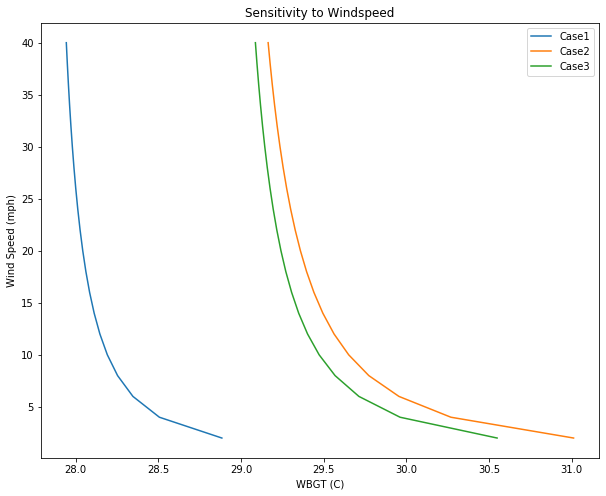

In [20]:
# Changing wind speeds

windspeed = np.arange(2.,42,2)

T,Td,WBT = 30,20.5,26.7755045
WBGT1 =WBGT_NWS(windspeed,T,Td,336,0.6707,992.83,WBT)

T,Td,WBT = 33.889,24.444,26.5755611
WBGT2 =WBGT_NWS(windspeed,T,Td,754,0.6397,981.94,WBT,Fdb=0.75,Fdif=0.25)

T,Td,WBT = 34.444,21.111,26.34526836
WBGT3 =WBGT_NWS(windspeed,T,Td,579,0.7227,991.84,WBT,Fdb=.75,Fdif=.25)


fig, ax = plt.subplots(figsize=(10,8))
plt.plot(WBGT1,windspeed,label='Case1')
plt.plot(WBGT2,windspeed,label='Case2')
plt.plot(WBGT3,windspeed,label='Case3')
plt.title('Sensitivity to Windspeed')
plt.legend()
fig.patch.set_facecolor('white')
plt.xlabel('WBGT (C)')
plt.ylabel('Wind Speed (mph)')
plt.show()

WBT:   26.7755045
cosZ:  0.7833867836891231
h:     0.315
ea:    22.561247578273452
Ea:    0.8974400193356646
B:     [7.26926416e+05 1.07623874e+09 2.15175055e+09 3.22726236e+09
 4.30277418e+09 5.37828599e+09 6.45379780e+09 7.52930961e+09
 8.60482143e+09 9.68033324e+09 1.07558451e+10 1.18313569e+10
 1.29068687e+10 1.39823805e+10]
C:     1197256882.1885445
GT:    [30.00060703 30.89872832 31.79684961 32.69497089 33.59309218 34.49121347
 35.38933476 36.28745605 37.18557734 38.08369862 38.98181991 39.8799412
 40.77806249 41.67618378] 

WBT:   26.5755611
cosZ:  0.8022748804197051
h:     0.315
ea:    28.485723358606265
Ea:    0.9278371082802895
B:     [1.22378959e+06 9.42512010e+08 1.88380023e+09 2.82508845e+09
 3.76637667e+09 4.70766489e+09 5.64895311e+09 6.59024133e+09
 7.53152955e+09 8.47281777e+09 9.41410599e+09 1.03553942e+10
 1.12966824e+10 1.22379707e+10]
C:     1309231603.4343324
GT:    [33.88917427 34.60799606 35.32681785 36.04563963 36.76446142 37.48328321
 38.202105   38.92092679 3

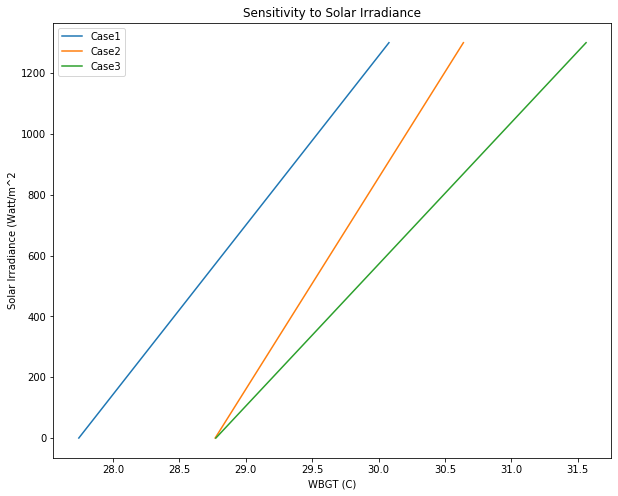

In [21]:
# Changing S

S = np.arange(0,1301,100)
T,Td,WBT = 30,20.5,26.7755045
WBGT1 =WBGT_NWS(6,T,Td,S,0.6707,992.83,WBT)

T,Td,WBT = 33.889,24.444,26.5755611
WBGT2 =WBGT_NWS(7,T,Td,S,0.6397,981.94,WBT,Fdb=0.75,Fdif=0.25)

T,Td,WBT = 34.444,21.111,26.34526836
WBGT3 =WBGT_NWS(3.7,T,Td,S,0.7227,991.84,WBT,Fdb=.75,Fdif=.25)

fig, ax = plt.subplots(figsize=(10,8))
plt.plot(WBGT1,S,label='Case1')
plt.plot(WBGT2,S,label='Case2')
plt.plot(WBGT3,S,label='Case3')
plt.title('Sensitivity to Solar Irradiance')
plt.legend()
fig.patch.set_facecolor('white')
plt.xlabel('WBGT (C)')
plt.ylabel('Solar Irradiance (Watt/m^2')
plt.show()

# References

Budd, G. M., 2008: Wet-bulb globe temperature (WBGT)--its history and its limitations. J Sci Med Sport, 11, 20–32, https://doi.org/10.1016/j.jsams.2007.07.003.

Dimiceli, V. E., S. F. Piltz, and S. A. Amburn, 2011: Estimation of Black Globe Temperature for Calculation of the Wet Bulb Globe Temperature Index. 9.

Hunter, C. H., and C. O. Minyard, 2.7 Estimating Wet Bulb Globe Temperature Using Standard Meteorological Measurements.

Lemke, B., and T. Kjellstrom, 2012: Calculating Workplace WBGT from Meteorological Data: A Tool for Climate Change Assessment. Ind Health, 50, 267–278, https://doi.org/10.2486/indhealth.MS1352.

Weatherly, J. W., and M. A. Rosenbaum, 2017: Future Projections of Heat and Fire-Risk Indices for the Contiguous United States. J. Appl. Meteor. Climatol., 56, 863–876, https://doi.org/10.1175/JAMC-D-16-0068.1.

2013: Wayback Machine. https://web.archive.org/web/20130322223430/http://armypubs.army.mil/med/dr_pubs/dr_a/pdf/tbmed507.pdf (Accessed November 30, 2020).

What is Wet Bulb Globe Temperature (WBGT)? Earth Networks,. https://www.earthnetworks.com/wet-bulb-globe-temperature/ (Accessed November 30, 2020b).
